# Multi-task Bayesian Optimization with GPy and GPyOpt

**Problem setting: let's say that we have two functions (tasks). Function no 0 is expensive to evaluate, whereas function no 1 is relatively cheap to evaluate. Furthermore, we assume that functions are related. Our objective is to find minimum of function no 0.**

 1) First, I demonstrate fitting functions with GP-regression independently and then using multi-task (coregionalized) kernel.

 2) Then, I show how Bayesian Optimization (BO) can be used to find the minimum of function no 0.

 3) Finally, by using multi-task kernel with BO and cost function, I present how to optimize function no 0 while relying mostly on evaluating function no 1.

## Imports

In [1]:
!pip install emcee GPy GPyOpt numpy matplotlib

In [2]:
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt

In [3]:
import pylab as pl
from IPython import display
import time

In [4]:
from matplotlib import pyplot as plt 
import numpy as np

## Auxiliary plotting

In [5]:
def plot_err(x, y, yerr, color=None, alpha_fill=0.2, ax=None, label="", lw=1, ls="-"):
    y, yerr = y.reshape(-1), yerr.reshape(-1)    
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, label=label, lw=lw, ls=ls)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidth=0.0)

## True functions (tasks)

In [6]:
f0 = lambda X: np.sin(6*X)
f1 = lambda X: np.sin(6*X+0.7)

In [7]:
plt_X = np.arange(-0.5, 1.55, 0.05)

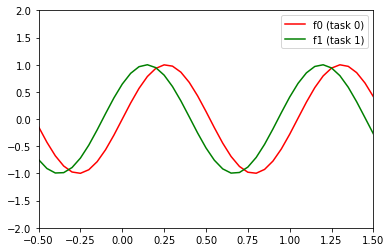

In [8]:
plt.plot(plt_X, f0(plt_X), color="red", label="f0 (task 0)")
plt.plot(plt_X, f1(plt_X), color="green", label="f1 (task 1)")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend();

## Functions' noisy samples

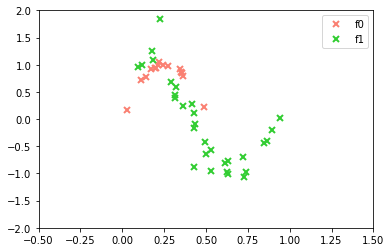

In [9]:
np.random.seed(123)
X0 = np.random.rand(15, 1) * 0.5
X1 = np.random.rand(30, 1) 
Y0 = f0(X0) + np.random.standard_t(3, X0.shape)*0.03
Y1 = f1(X1) + np.random.standard_t(3, X1.shape)*0.1

plt.plot(X0, Y0, 'x', mew=2, color="salmon", label="f0")
plt.plot(X1, Y1, 'x', mew=2, color="limegreen", label="f1")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend();

## Fitting individual regressions separately (using noisy samples)

### Kernel

In [10]:
def get_kernel_basic():
    return GPy.kern.RBF(1, active_dims=[0], lengthscale=1.0)

### Function 0

In [11]:
model = GPy.models.GPRegression(X0, Y0, get_kernel_basic())

In [12]:
print("Model before optimization:")
model

Model before optimization:


GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


**Note that apart from kernel parameters we have one model parameter (likelihood noise).**

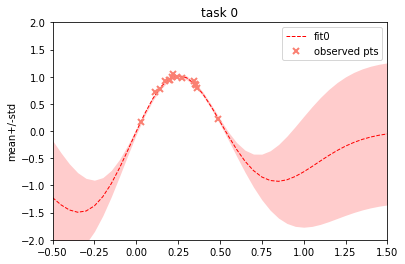

In [13]:
model.optimize()

#model.plot(plot_data=False, plot_inducing=False) # 95%-CI
means0, var = model.predict(np.transpose(plt_X.reshape(1,-1)))
stds0 = np.sqrt(var)
plot_err(plt_X, means0, stds0, lw=1, ls="--", color="red", label="fit0")
plt.plot(X0, Y0, 'x', mew=2, color="salmon", label="observed pts")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend(); plt.title("task 0"); plt.ylabel("mean+/-std");

In [14]:
print("Model after optimization:")
model

Model after optimization:


GP_regression.,value,constraints,priors
rbf.variance,1.710175229312716,+ve,
rbf.lengthscale,0.3382803284370218,+ve,
Gaussian_noise.variance,0.0010431177594203518,+ve,


### Function 1

In [15]:
model = GPy.models.GPRegression(X1, Y1, get_kernel_basic())
model

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


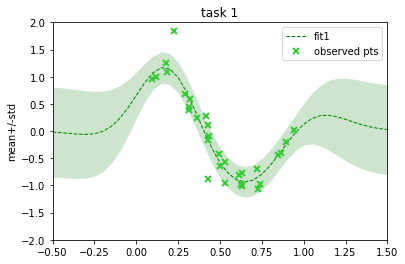

In [16]:
model.optimize()

#model.plot(plot_data=False, plot_inducing=False) # 95%-CI
means1, var = model.predict(np.transpose(plt_X.reshape(1,-1)))
stds1 = np.sqrt(var)
plot_err(plt_X, means1, stds1, lw=1, ls="--", color="green", label="fit1")
plt.plot(X1, Y1, 'x', mew=2, color="limegreen", label="observed pts")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend(); plt.title("task 1"); plt.ylabel("mean+/-std");

In [17]:
print("Model after optimization:")
model

Model after optimization:


GP_regression.,value,constraints,priors
rbf.variance,0.6139153695082971,+ve,
rbf.lengthscale,0.21631463550051322,+ve,
Gaussian_noise.variance,0.06988647781389631,+ve,


## Multi-task regression

**Conversion of multi-task to one-task is performed by merging tasks and adding one `special' dimension indicating task number.**

In [18]:
# Augment the X data with ones or zeros to indicate the required task number
task0_column = np.zeros((X0.shape[0],1))
task1_column = np.ones((X1.shape[0],1))
X = np.vstack((np.hstack((X0, task0_column)), np.hstack((X1, task1_column))))

# Augment the Y data to indicate accordingly to how tasks were stacked in X
Y = np.vstack([Y0, Y1])

In [19]:
# a Coregionalization kernel. The base kernel acts on the first ([0]) data dimension.
# the 'Coregionalize' kernel indexes the outputs, and acts on the second ([1]) `special' data dimension
def get_kernel_mt():
    kern_corg = GPy.kern.Coregionalize(1, output_dim=2, rank=1)
    kern_mt = get_kernel_basic()**kern_corg
    return kern_mt

In [20]:
kern_mt = get_kernel_mt()

In [21]:
print("Hyperparams before learning")
print("(we observe parameters of base kernel, coregionalization kernel, and likelihood parameters.)")
for k in kern_mt.parameters:
    print("----------")
    print(k)
print("W:\n",kern_mt[".*W.*"])
print("kappa:\n",kern_mt[".*kappa.*"])

Hyperparams before learning
(we observe parameters of base kernel, coregionalization kernel, and likelihood parameters.)
----------
  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        
----------
  coregion.  |   value  |  constraints  |  priors
  W          |  (2, 1)  |               |        
  kappa      |    (2,)  |      +ve      |        
W:
   index  |  mul.coregion.W  |  constraints  |  priors
  [0 0]  |     -0.52449584  |               |        
  [1 0]  |     -0.03756029  |               |        
kappa:
   index  |  mul.coregion.kappa  |  constraints  |  priors
  [0]    |          0.50000000  |      +ve      |        
  [1]    |          0.50000000  |      +ve      |        


In [22]:
# Model definition
model = GPy.models.GPRegression(X, Y, kern_mt)
model.optimize()

In [23]:
print("Hyperparams after learning")
print("(we observe parameters of base kernel, coregionalization kernel, and likelihood parameters.)")
for k in kern_mt.parameters:
    print("----------")
    print(k)
print("W:\n",kern_mt[".*W.*"])
print("kappa:\n",kern_mt[".*kappa.*"])

Hyperparams after learning
(we observe parameters of base kernel, coregionalization kernel, and likelihood parameters.)
----------
  rbf.         |               value  |  constraints  |  priors
  variance     |  0.4713425557457229  |      +ve      |        
  lengthscale  |  0.2025235505108066  |      +ve      |        
----------
  coregion.  |   value  |  constraints  |  priors
  W          |  (2, 1)  |               |        
  kappa      |    (2,)  |      +ve      |        
W:
   index  |  GP_regression.mul.coregion.W  |  constraints  |  priors
  [0 0]  |                   -0.71984629  |               |        
  [1 0]  |                   -1.01321004  |               |        
kappa:
   index  |  GP_regression.mul.coregion.kappa  |  constraints  |  priors
  [0]    |                        0.22741953  |      +ve      |        
  [1]    |                        0.30819705  |      +ve      |        


In [24]:
# print("Plotting 95%-Confidence intervals")
# for i in range(2):
#     model.plot(fixed_inputs=[(1, i)],  plot_data=False, plot_inducing=False)
#     plt.plot(X0, Y0, 'x', mew=2, color="salmon")
#     plt.plot(X1, Y1, 'x', mew=2, color="limegreen")    
#     plt.title("task %s" % i)    

## Compare multi-task vs individual regression fits

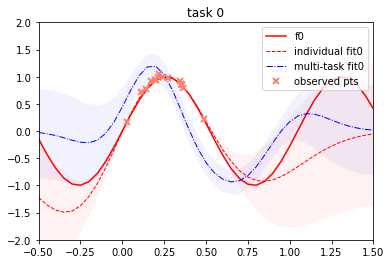

In [25]:
plt.plot(plt_X, f0(plt_X), color="red", label="f0")

plot_err(plt_X, means0, stds0, lw=1, ls="--", color="red", label="individual fit0", alpha_fill=0.05)

task_column =  np.ones((plt_X.shape[0],1))
xt = np.hstack([plt_X.reshape(-1,1), task_column])
means0mt, var = model.predict(xt)
stds0mt = np.sqrt(var)
plot_err(plt_X, means0mt, stds0mt, lw=1, ls="-.", color="blue", label="multi-task fit0", alpha_fill=0.05)

plt.plot(X0, Y0, 'x', mew=2, color="salmon", label="observed pts")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend(); plt.title("task 0");

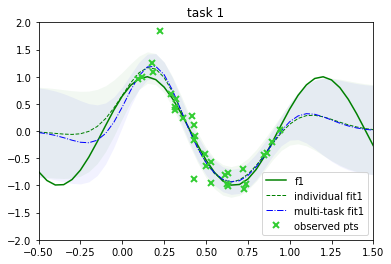

In [26]:
plt.plot(plt_X, f1(plt_X), color="green", label="f1")

plot_err(plt_X, means1, stds1, lw=1, ls="--", color="green", label="individual fit1", alpha_fill=0.05)

task_column =  np.ones((plt_X.shape[0],1))
xt = np.hstack([plt_X.reshape(-1,1), task_column])
means1mt, var = model.predict( xt )
stds1mt = np.sqrt(var)
plot_err(plt_X, means1mt, stds1mt, lw=1, ls="-.", color="blue", label="multi-task fit1", alpha_fill=0.05)

plt.plot(X1, Y1, 'x', mew=2, color="limegreen", label="observed pts")
plt.xlim(-0.5,1.5); plt.ylim(-2,2); plt.legend(); plt.title("task 1");

## Task 0 Individual Optimization

### Auxiliary plotting

In [27]:
def plot_next_acquisitions(bo, DIM_NO=0):
    for x in bo.suggest_next_locations():
        plt.axvline(x=x[DIM_NO], color="salmon", ls="--", lw=2, label="next acquisition")

In [28]:
def plot_acquisition(bo, DIM_NO=0, grid=0.001):
    bounds = bo.acquisition.space.get_bounds()
    x_grid = np.arange(bounds[DIM_NO][0], bounds[DIM_NO][1], grid)
    x_grid = x_grid.reshape(len(x_grid),1)
    acqu0 = -bo.acquisition.acquisition_function(x_grid)
    plt.plot(x_grid, acqu0, label="task 0", color="red", lw=2)
    
    plot_next_acquisitions(bo, DIM_NO)    
    plt.xlim(-0.6,1.6); plt.legend(loc=2); plt.title("acquisition function"); plt.grid();

In [29]:
def plot_task(bo):
    plt.plot(plt_X, f0(plt_X), color="red", label="f0")
    # note the difference in returned value vs. regression model
    means0mt, stds0mt = bo.model.predict( plt_X.reshape(-1,1) ) 
    plot_err(plt_X, means0mt, stds0mt, lw=1, ls="-.", color="blue", label="BO fit0", alpha_fill=0.2)

    X,Y = bo.get_evaluations()
    plt.scatter(X,Y, color="k", marker="x", label="acquisition pts")
    
    plot_next_acquisitions(bo)
    plt.xlim(-0.6,1.6); plt.ylim(-2,2); plt.legend(loc=2); plt.title("function fit"); plt.grid()

In [30]:
RENAME = {"Gaussian_noise.variance": "noise.var"}

def plot_params(bo):
    plt.xlim(-1,1); plt.ylim(-1,1); plt.axis('off');
    
    for i, (n, v) in enumerate(zip(bo.model.get_model_parameters_names(), bo.model.get_model_parameters()[0])):        
        n = ".".join(n.split(".")[-2:])
        n = RENAME.get(n, n)
        plt.text(-0.9, 0.9-i*0.2, "%s:" % (n), ha="left", va="top", fontsize=13)    
        plt.text(0.5, 0.9-i*0.2, "%.3f" % (v), ha="left", va="top", fontsize=13)    

In [31]:
def plot_bo(bo):  
    plt.figure(figsize=(18,4))
    plt.subplot(1,3,1)
    plot_task(bo); 
    plt.subplot(1,3,2)
    plot_acquisition(bo)
    plt.subplot(1,3,3)
    plot_params(bo)

### Optimization

In [32]:
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (-0.5,1.5)}]        

In [33]:
initial_iter = 3
max_iter  = 10                           
kernel = get_kernel_basic()

In [34]:
objective = GPyOpt.core.task.SingleObjective(f0)

In [35]:
model = GPyOpt.models.GPModel(optimize_restarts=5, verbose=False, kernel=kernel)
space = GPyOpt.Design_space(space=bounds)
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
initial_design = GPyOpt.experiment_design.initial_design('random', space, initial_iter)

# EI
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, optimizer=aquisition_optimizer)

# ES (experimental implementation)
# from GPyOpt.util import mcmc_sampler
# sampler = mcmc_sampler.AffineInvariantEnsembleSampler(space)
# acquisition = GPyOpt.acquisitions.AcquisitionEntropySearch(model, space, 
#                                                            optimizer=aquisition_optimizer, sampler=sampler)


evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design)

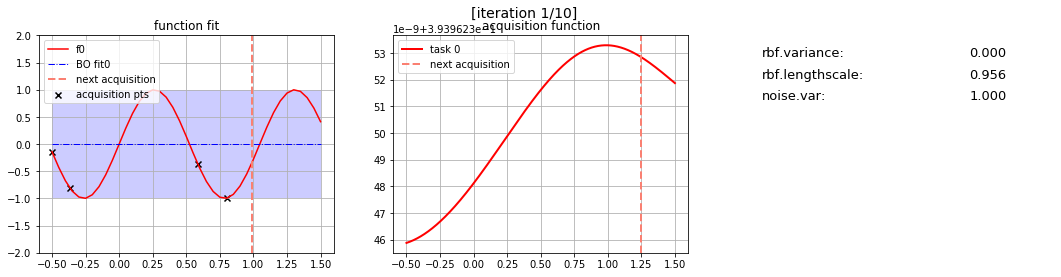

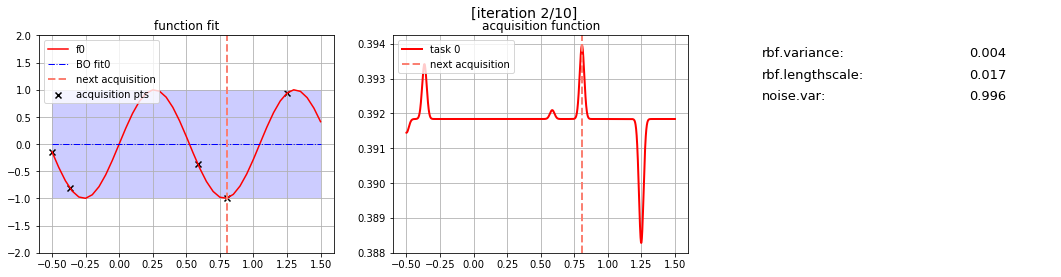

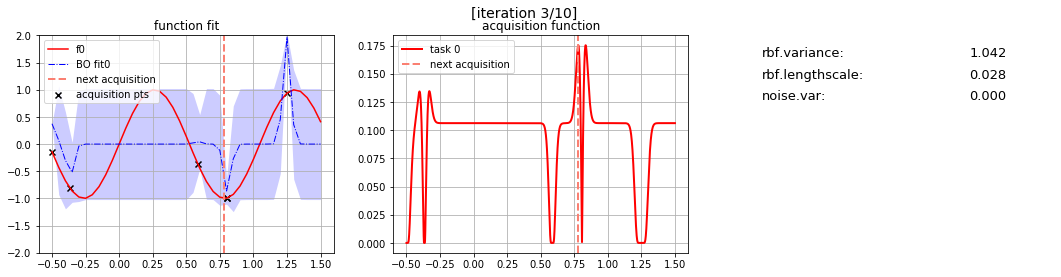

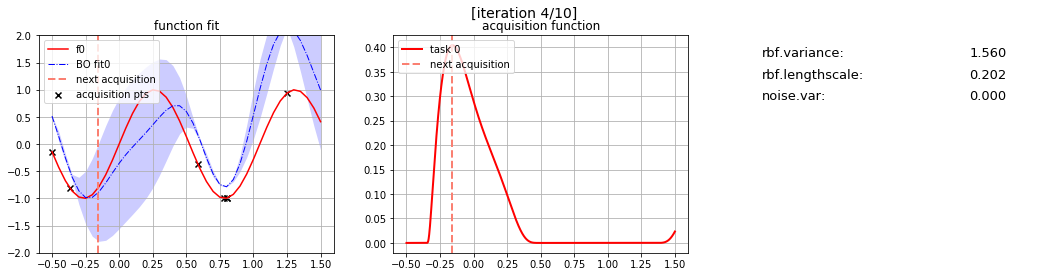

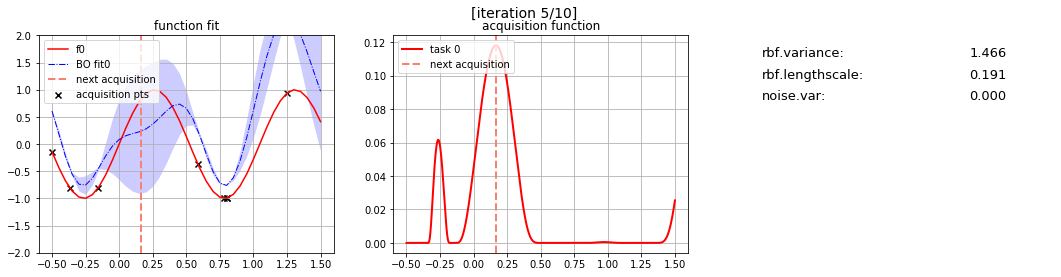

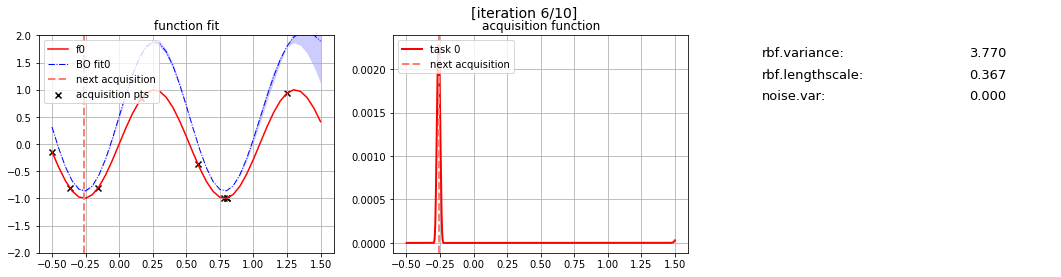

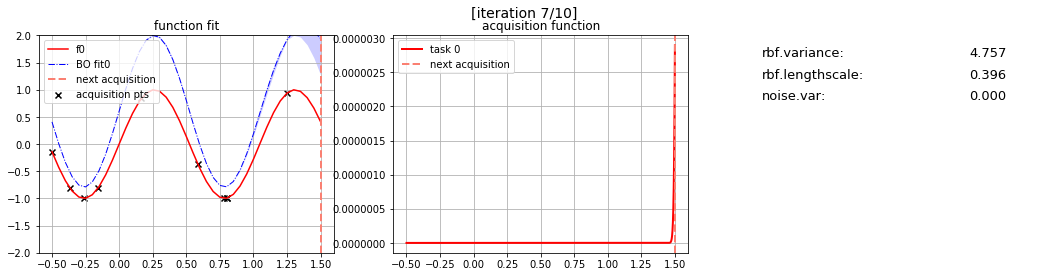

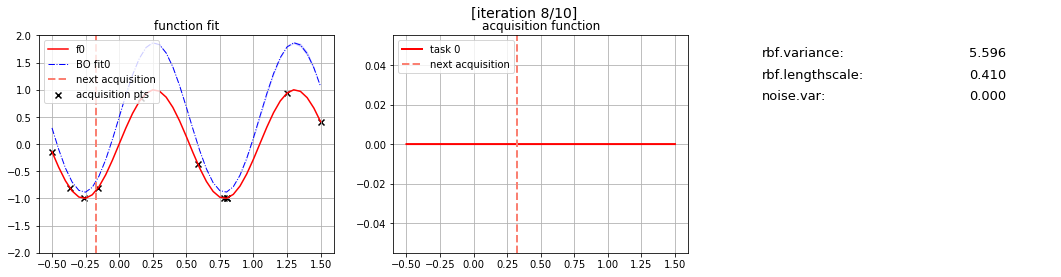

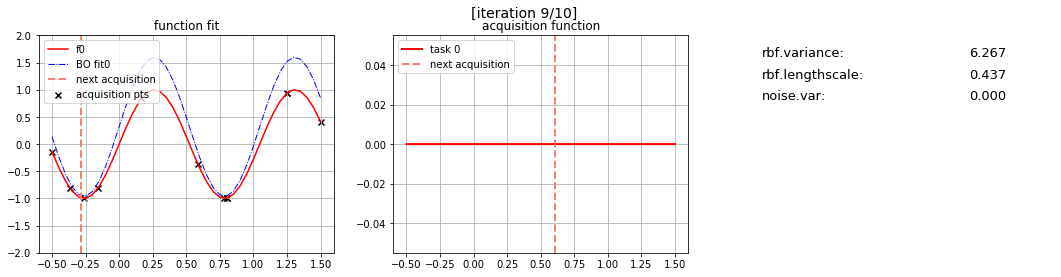

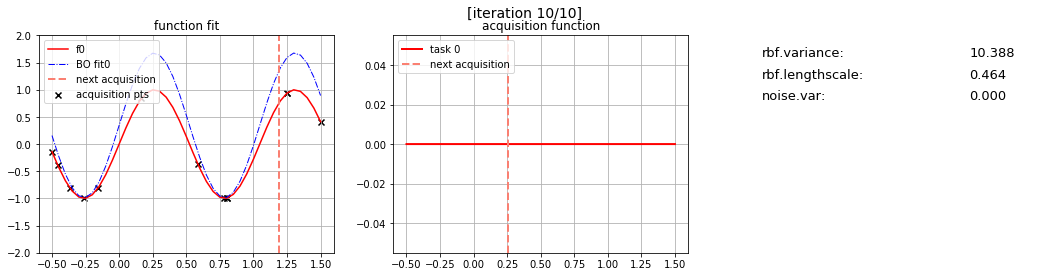

In [36]:
#bo.run_optimization(max_iter = max_iter) 
for i in range(1, max_iter+1):    
    bo.run_optimization(1)    
    
    time.sleep(1.0);  
    plot_bo(bo)    
    plt.gcf().suptitle("[iteration %i/%i]" % (i, max_iter), fontsize=14)    
    display.display(pl.gcf()); 
    display.clear_output(wait=True)    

**'Next acquistion' positions may not match on different plots since each plot queries BO independenly, and for every query independent optimization is performed.**

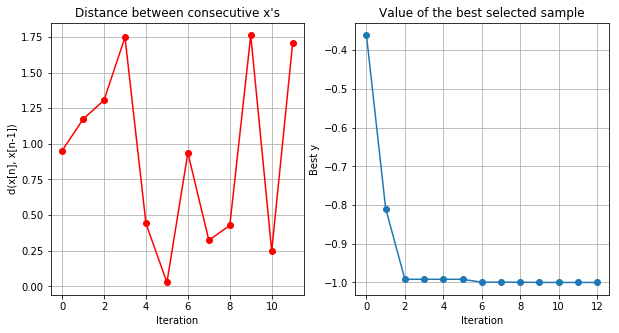

In [37]:
#bo.plot_acquisition()
bo.plot_convergence()

In [38]:
print("x_opt=%s, f(x_opt)=%s" % (bo.x_opt, bo.fx_opt))

x_opt=[-0.2614615], f(x_opt)=-0.9999979449468079


## Multi-task Optimization

### Auxiliary plotting

In [39]:
def plot_next_acquisitions(bo, DIM_NO=0, tasks_to_be_plotted=[0,1]):
    for xt in bo.suggest_next_locations():
        x, t = xt[:-1], int(xt[-1])
        assert t==0 or t==1 # only two tasks allowed for now
        if t not in tasks_to_be_plotted: continue
        plt.axvline(x=x[DIM_NO], color=("salmon" if t==0 else "limegreen"), 
                    ls="--", lw=2, label="next acquisition")

In [40]:
def plot_acquisition(bo, DIM_NO=0, grid=0.001):

    bounds = bo.acquisition.space.get_bounds()

    x_grid = np.arange(bounds[DIM_NO][0], bounds[DIM_NO][1], grid)
    x_grid = x_grid.reshape(len(x_grid),1)

    xt = np.hstack([x_grid, np.zeros((x_grid.shape[0],1))]) # task 0
    acqu0 = -bo.acquisition.acquisition_function(xt)
    plt.plot(x_grid, acqu0, label="task 0", color="red", lw=2)

    xt = np.hstack([x_grid, np.ones((x_grid.shape[0],1))]) # task 1
    acqu1 = -acquisition.acquisition_function(xt)
    plt.plot(x_grid, acqu1, label="task 1", color="green", lw=2)

    #xt = np.hstack([x_grid, np.ones((x_grid.shape[0],1))*0.5]) # task 0.5
    #acqu05 = -acquisition.acquisition_function(xt)
    #plt.plot(x_grid, acqu05, label="task 0.5", color="blue", lw=2)
    
    plot_next_acquisitions(bo, DIM_NO, [0, 1])    
    plt.xlim(-0.6,1.6); plt.legend(loc=2); plt.title("acquisition function"); plt.grid();

In [41]:
def plot_task(bo, TASK_NO): # TODO cover multi-dimensional inputs
    f, color = {0: (f0, "red"), 1: (f1, "green")}[TASK_NO]    
    plt.plot(plt_X, f(plt_X), color=color, label="f0")

    task_column = TASK_NO*np.ones((plt_X.shape[0],1))
    xt = np.hstack([plt_X.reshape(-1,1), task_column])
    means0mt, stds0mt = bo.model.predict(xt)
    plot_err(plt_X, means0mt, stds0mt, lw=1, ls="-.", color="blue", label="BO fit%i" % TASK_NO, alpha_fill=0.05)

    X, Y = bo.get_evaluations()
    if len(X)>0 and X[-1,1]==TASK_NO:
        plt.scatter(X[-1,0],Y[-1,0], color=color, marker="o", s=60, label="prev acquisition")        
    Y, X  = Y[X[:,1]==TASK_NO], X[X[:,1]==TASK_NO,0]
    plt.scatter(X,Y, color="k", marker="x", label="acquisition pts")        

    plot_next_acquisitions(bo, 0, [TASK_NO])    
    plt.xlim(-0.6,1.6); plt.ylim(-2,2); plt.legend(loc=2); plt.title("task %i" % TASK_NO); plt.grid();

In [42]:
def plot_bo(bo):
    plt.figure(figsize=(22,4))
    plt.subplot(1,4,1)
    plot_task(bo, 0); 
    plt.subplot(1,4,2)
    plot_task(bo, 1) 
    plt.subplot(1,4,3)  
    plot_acquisition(bo)
    plt.subplot(1,4,4)  
    plot_params(bo)

### Tasks specification

In [43]:
# MT optimization objective

task_counter = {} # how many times each task was evaluated

def mt_objective(xt):
    assert len(xt)==1 # one sample per batch
    xt = xt[0]     
    x, t = xt[:-1], int(xt[-1]) # extract coordinates and task number
    
    task_counter[t] = task_counter.get(t, 0)+1
    #print("evaluating task=%s at x=%s  (#evaluations per task: %s)" % (t, np.round(x,2), task_counter))
    func = {0: f0, 1: f1}[t]
    return func(x)

In [44]:
# Evaluation costs

def cost_const(xt): # constant cost baseline
    return np.ones(xt.shape[0])[:,None], np.zeros(xt.shape)


C0 = 10.0 # task 0 evaluation cost
C1 = 1.0 # task 1 evaluation cost

def cost_mt(xt): # different cost for different task no   
    t2c = {0: C0, 1: C1} # task to cost
    t2g = {0: [0.0, (C1-C0)], 1: [0.0, (C1-C0)]} # task to gradient # TODO Correct???
    
    costs = np.array([[t2c[int(t)]] for t in xt[:,-1]])        
    gradients = np.array([t2g[int(t)] for t in xt[:,-1]])        
    return costs, gradients 

In [45]:
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (-0.5, 1.5)},
          {'name': 'var_2', 'type': 'discrete', 'domain': (0, 1)}] #second variable denotes task number

### Model specification

In [46]:
initial_iter = 3
max_iter  = 10                                 
kernel = get_kernel_mt()

#cost = cost_const
cost = cost_mt # with this cost, acquisition function for task 1 is downweighted (flattened)

**Try switching between cost_const and cost_mt**

In [47]:
objective = GPyOpt.core.task.SingleObjective(mt_objective)

In [48]:
model = GPyOpt.models.GPModel(optimize_restarts=5, verbose=False, kernel=kernel)
space = GPyOpt.Design_space(space=bounds)
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
initial_design = GPyOpt.experiment_design.initial_design('random', space, initial_iter)

# EI
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, optimizer=aquisition_optimizer, cost_withGradients=cost)

# ES (experimental implementation)
# from GPyOpt.util import mcmc_sampler
# sampler = mcmc_sampler.AffineInvariantEnsembleSampler(space)
# acquisition = GPyOpt.acquisitions.AcquisitionEntropySearch(model, space, 
#                                                            optimizer=aquisition_optimizer, sampler=sampler,
#                                                            cost_withGradients=cost)


evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design)

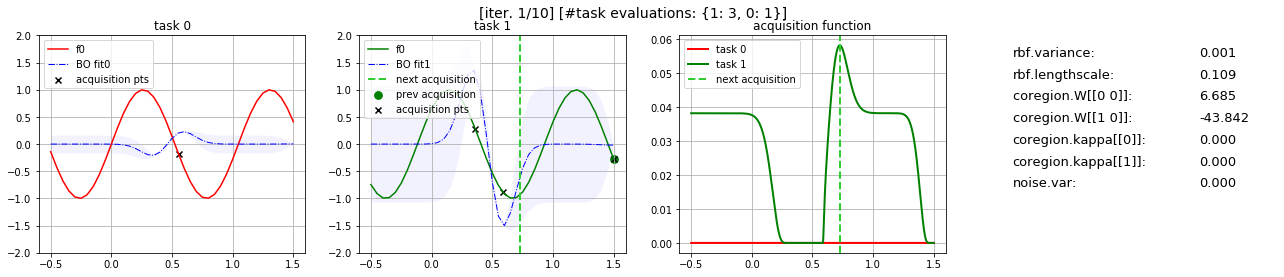

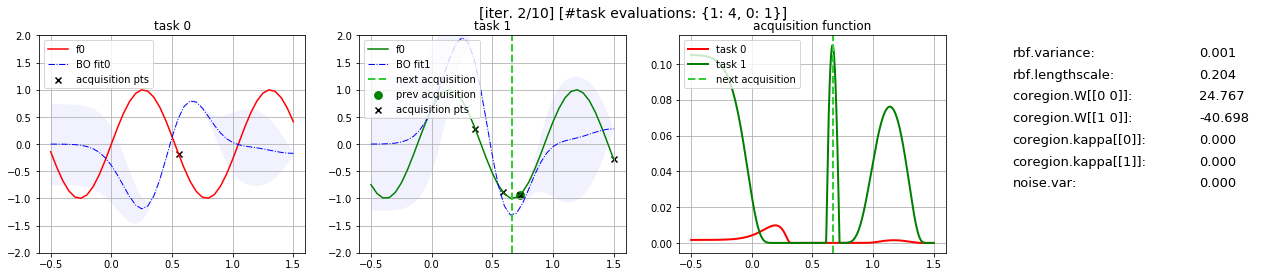

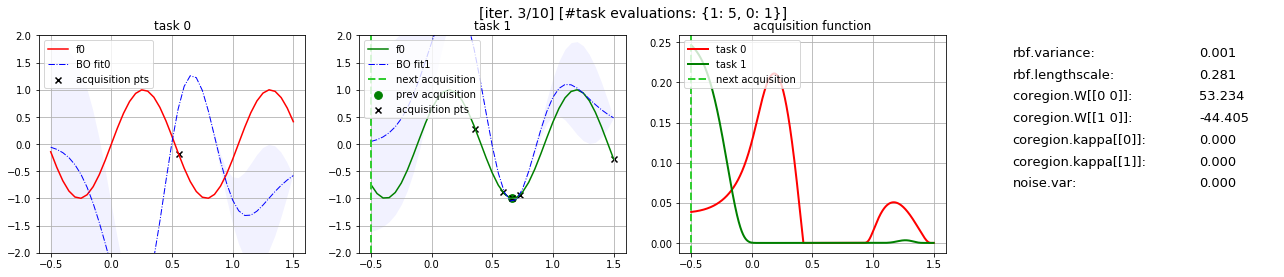

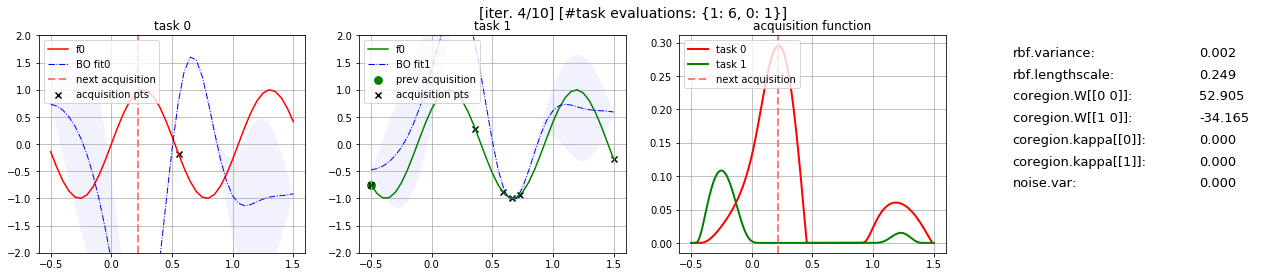

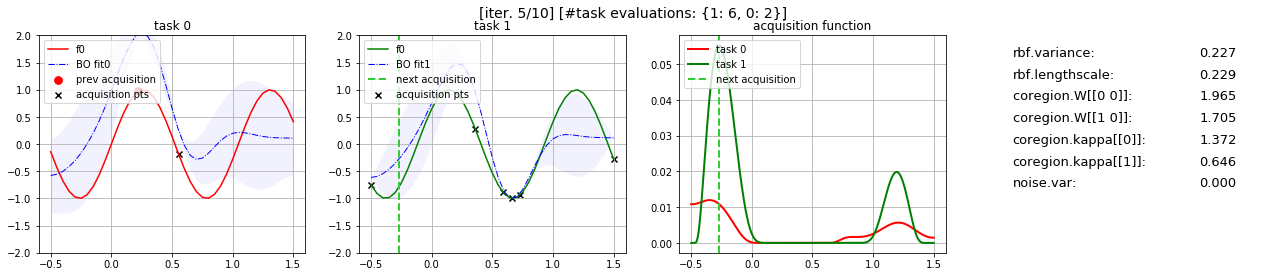

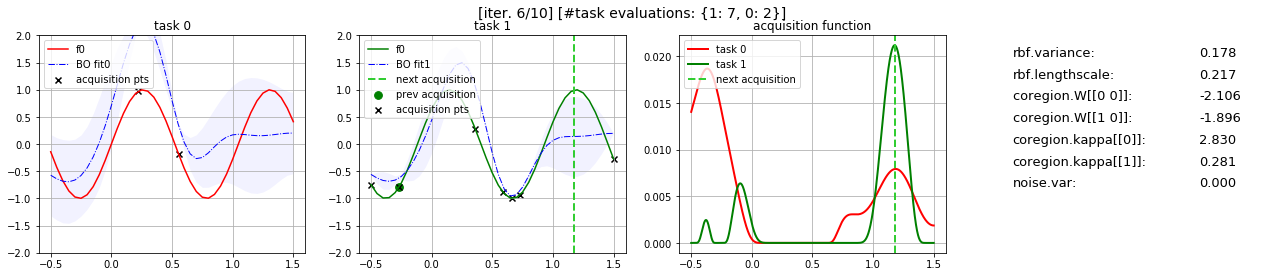

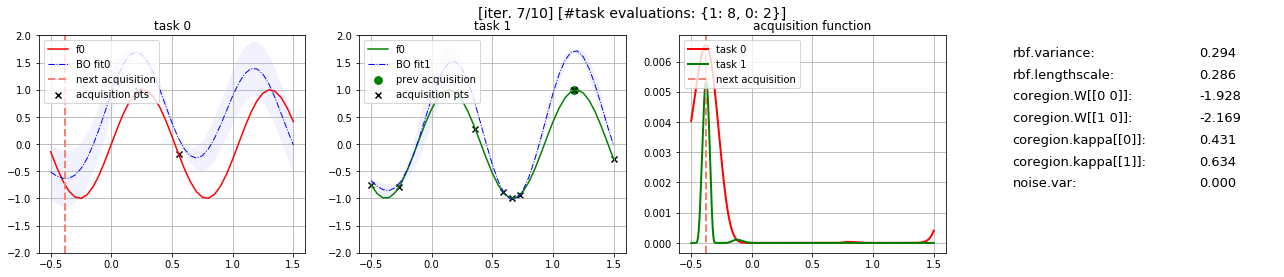

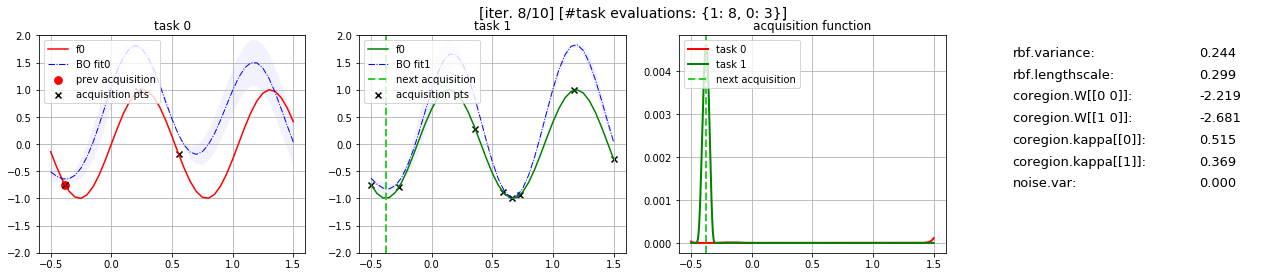

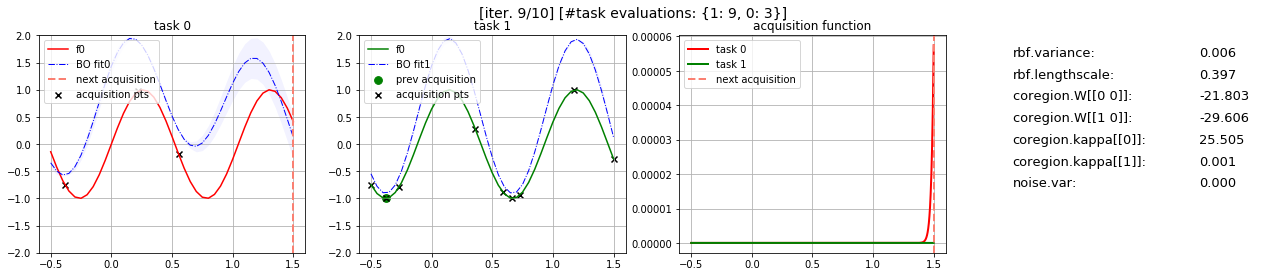

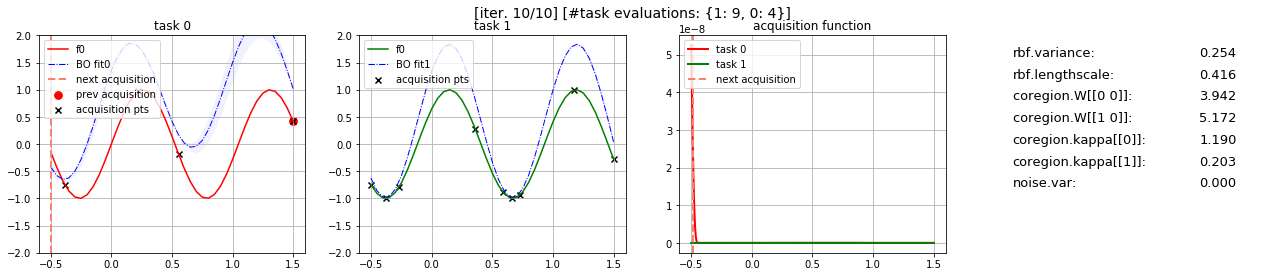

In [49]:
#bo.run_optimization(max_iter = max_iter) 
for i in range(1, max_iter+1):
    bo.run_optimization(1)  
    
    time.sleep(1.0);        
    plot_bo(bo)    
    plt.gcf().suptitle("[iter. %i/%i] [#task evaluations: %s]" % (i, max_iter, task_counter), fontsize=14)            
    display.display(pl.gcf());
    display.clear_output(wait=True);

**'Next acquistion' positions may not match on different plots since each plot queries BO independenly, and for every query independent optimization is performed.**

**TODO: decide where to perform the final evaluation of function 0.**

**TODO: decide when to stop using optimization current status instead of using predefined number of iterations.**

In [50]:
print("x_opt=%s, f(x_opt)=%s, task_counts=%s" % (bo.x_opt, bo.fx_opt, task_counter))

x_opt=[-0.3774168  1.       ], f(x_opt)=-0.9999801832888964, task_counts={1: 9, 0: 4}


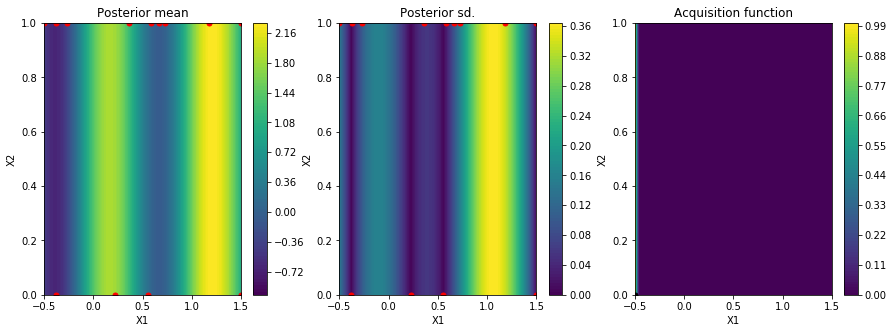

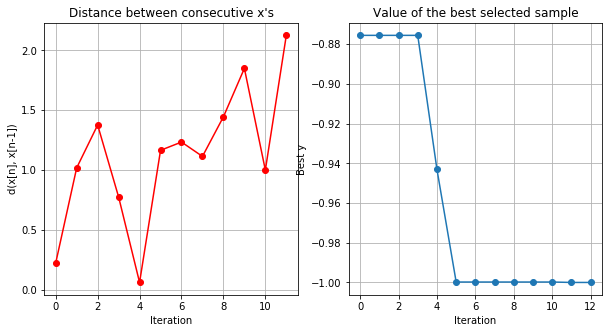

In [51]:
bo.plot_acquisition()
bo.plot_convergence()

**GPyOpt doesn't know that we do multi-task; when plotting treats the second dimension in the same way as the first one.**

## One-line optimization interface (for reference)

In [52]:
task_counter = {}

In [53]:
bo = GPyOpt.methods.BayesianOptimization(mt_objective, 
                                         bounds, 
                                         kernel = get_kernel_mt(), 
                                         acquisition='EI', 
                                         initial_design_numdata=initial_iter,
                                         cost_withGradients=cost)

In [54]:
bo.run_optimization(max_iter=max_iter)

In [55]:
print("x_opt=%s, f(x_opt)=%s, task_counts=%s" % (bo.x_opt, bo.fx_opt, task_counter))

x_opt=[0.69088659 1.        ], f(x_opt)=-0.9911777338769799, task_counts={0: 4, 1: 9}


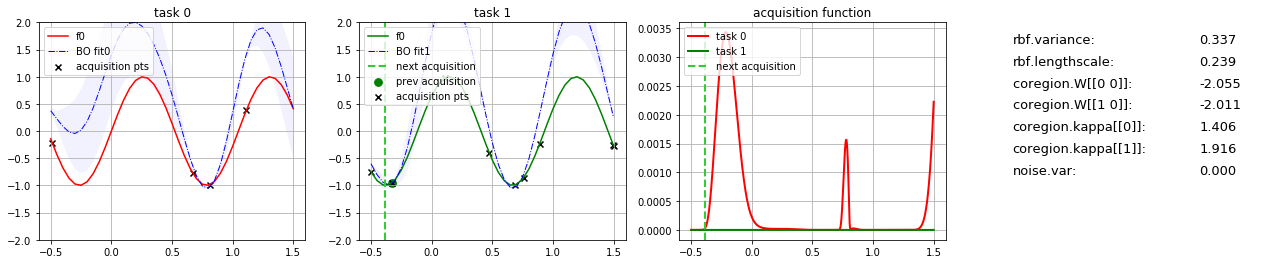

In [56]:
plot_bo(bo)

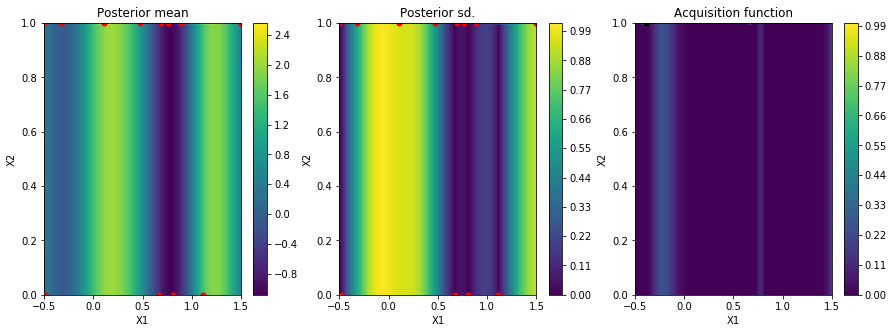

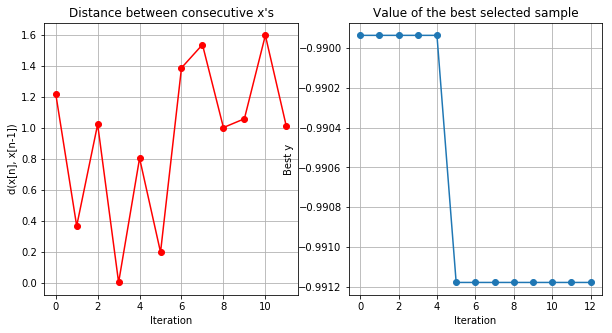

In [57]:
bo.plot_acquisition()
bo.plot_convergence()